# **Training, Optimization and Evaluation**

### **_IMPORTS_**

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import torch_directml  # for my AMD GPU
import torch.nn.functional as F

from skorch import NeuralNetClassifier
from sklearn.metrics import classification_report
from torch.nn import CrossEntropyLoss
from torchvision import models
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

Notebook "data_preprocessing.ipynb" run to get variables:


📂 TRAIN SET
NORMAL: 3875 images
PNEUMONIA: 3875 images

📂 VAL SET
NORMAL: 8 images
PNEUMONIA: 8 images

📂 TEST SET
NORMAL: 234 images
PNEUMONIA: 390 images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Deleted: ../data/chest_xray/train/NORMAL\NORMAL2-IM-1226-0001_aug1.jpg
Deleted: ../data/chest_xray/train/NORMAL\IM-0238-0001_aug0.jpg
Deleted: ../data/chest_xray/train/NORMAL\IM-0432-0001_aug1.jpg
Deleted: ../data/chest_xray/train/NORMAL\IM-0491-0001-0002_aug0.jpg
Deleted: ../data/chest_xray/train/NORMAL\IM-0203-0001_aug1.jpg
Deleted: ../data/chest_xray/train/NORMAL\NORMAL2-IM-0673-0001_aug1.jpg
Deleted: ../data/chest_xray/train/NORMAL\NORMAL2-IM-0945-0001_aug0.jpg
Deleted: ../data/chest_xray/train/NORMAL\IM-0666-0001-0001_aug1.jpg
Deleted: ../data/chest_xray/train/NORMAL\NORMAL2-IM-1196-0001_aug0.jpg
Deleted: ../data/chest_xray/train/NORMAL\NORMAL2-IM-0924-0001_aug1.jpg
Deleted: ../data/chest_xray/train/NORMAL\NORMAL2-IM-0912-0001_aug0.jpg
Deleted: ../data/chest_xray/train/NORMAL\IM-0149-0001_aug0.jpg
Deleted: ../data/chest_xray/train/NORMAL\IM-0293-0001_aug0.jpg
Deleted: ../data/chest_xray/train/NORMAL\NORMAL2-IM-1323-0001_aug0.jpg
Deleted: ../data/chest_xray/train/NORMAL\IM-0501-000

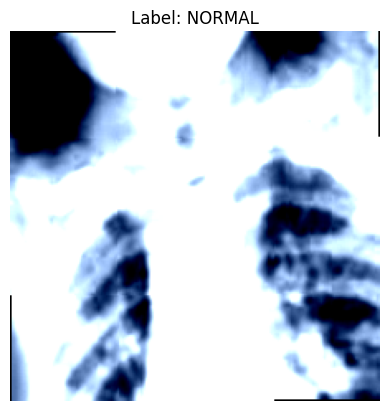

In [118]:
%run load_and_preprocess_data.ipynb

### **_MODEL_**

using my amd gpu to train models faster

In [119]:
device = torch_directml.device()  # or torch.device("cuda") for NVIDIA, "cpu" as fallback

In [ ]:
# EfficientNet load (without Top Layer)
weights = EfficientNet_B0_Weights.DEFAULT
base_model = efficientnet_b0(weights=weights)

# all layers freez
for param in base_model.parameters():
    param.requires_grad = False

# Custom Head
class CustomEfficientNet(nn.Module):
    def __init__(self, base_model):
        super(CustomEfficientNet, self).__init__()
        self.base = base_model.features
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.bn = nn.BatchNorm1d(base_model.classifier[1].in_features)
        self.fc1 = nn.Linear(base_model.classifier[1].in_features, 256)
        self.dropout = nn.Dropout(0.45)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.base(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.bn(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CustomEfficientNet(base_model).to(device)


### **_Train Model_**

In [ ]:
min_val_loss = float('inf')
early_stop = 10
epochs = 20
learning_rate = 0.0001                  
weights = torch.tensor([1.0, 1.0], device=device)  # Increases weight for ‘NORMAL’ class

criterion = CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

In [ ]:
for epoch in range(epochs):
    model.train()
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    model.eval()
    val_losses = []
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            
            outputs = model(x_batch)
            val_losses.append(criterion(outputs, y_batch).item())

    val_loss = np.mean(val_losses)
    scheduler.step(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss:.4f}")


    if epoch == 5:
        for param in model.base.parameters():
            param.requires_grad = True
        optimizer = optim.Adam(model.parameters(), lr=1e-5)  # Smaller LR for Fine-Tuning



    if early_stop_count >= early_stop:
        print("Early stopping!")
        break

Epoch 1/20, Validation Loss: 0.5078
Epoch 2/20, Validation Loss: 0.7374
Epoch 3/20, Validation Loss: 0.4945
Epoch 4/20, Validation Loss: 0.6246
Epoch 5/20, Validation Loss: 0.5136
Epoch 6/20, Validation Loss: 0.4435
Epoch 7/20, Validation Loss: 0.4488
Epoch 8/20, Validation Loss: 0.3463
Epoch 9/20, Validation Loss: 0.5800
Epoch 10/20, Validation Loss: 0.4488
Epoch 11/20, Validation Loss: 0.4142
Epoch 12/20, Validation Loss: 0.2950
Epoch 13/20, Validation Loss: 0.2222
Epoch 14/20, Validation Loss: 0.3544
Epoch 15/20, Validation Loss: 0.3652
Epoch 16/20, Validation Loss: 0.2427
Epoch 17/20, Validation Loss: 0.2295
Epoch 18/20, Validation Loss: 0.2357
Epoch 19/20, Validation Loss: 0.2259
Epoch 20/20, Validation Loss: 0.2646


### **_Test Model_**

In [125]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        outputs = model(x_batch)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 92.95%


### **_Evaluation_**

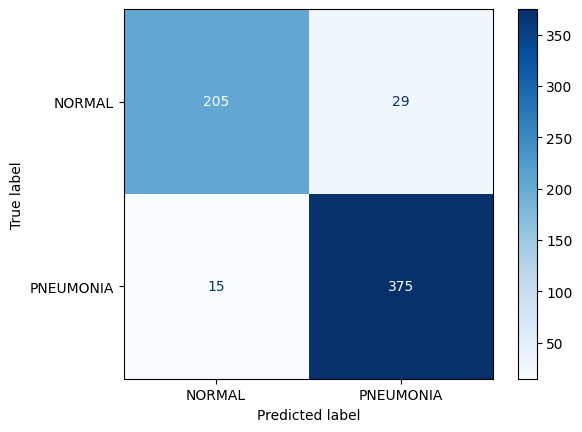

In [128]:
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        outputs = model(x_batch)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NORMAL", "PNEUMONIA"])
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [129]:
print(classification_report(y_true, y_pred, target_names=["NORMAL", "PNEUMONIA"]))


              precision    recall  f1-score   support

      NORMAL       0.93      0.88      0.90       234
   PNEUMONIA       0.93      0.96      0.94       390

    accuracy                           0.93       624
   macro avg       0.93      0.92      0.92       624
weighted avg       0.93      0.93      0.93       624



In [ ]:
save_path = os.path.abspath("../saved_models/efficientnet_weights.pth")
os.makedirs(os.path.dirname(save_path), exist_ok=True)

torch.save(model.state_dict(), save_path)
